# Open University Learning Analytics Dataset (OULAD) — Student Success Prediction 



In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import statsmodels.api as sm

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Versions:")
print("  pandas      :", pd.__version__)
print("  numpy       :", np.__version__)
print("  matplotlib  :", plt.matplotlib.__version__)
print("  seaborn     :", sns.__version__)
print("  scipy       :", scipy.__version__)
print("  scikit-learn:", sklearn.__version__)
print("  statsmodels :", sm.__version__)


Versions:
  pandas      : 2.3.3
  numpy       : 2.2.6
  matplotlib  : 3.10.8
  seaborn     : 0.13.2
  scipy       : 1.15.3
  scikit-learn: 1.7.2
  statsmodels : 0.14.6


In [6]:
#Import CSV files
def read_data(name_dir):
    df=pd.read_csv(name_dir)
    return df

assessments = r"C:\Users\ento3\Downloads\OULAD\assessments.csv"
courses = r"C:\Users\ento3\Downloads\OULAD\courses.csv"
student_assessment = r"C:\Users\ento3\Downloads\OULAD\studentAssessment.csv"
student_info = r"C:\Users\ento3\Downloads\OULAD\studentInfo.csv"
student_registration = r"C:\Users\ento3\Downloads\OULAD\studentRegistration.csv"
student_vle = r"C:\Users\ento3\Downloads\OULAD\studentVle.csv"
vle = r"C:\Users\ento3\Downloads\OULAD\vle.csv"

df_assessments = read_data(assessments)
df_courses = read_data(courses)
df_student_assessment = read_data(student_assessment)
df_student_info = read_data(student_info)
df_student_registration = read_data(student_registration)
df_student_vle = read_data(student_vle)
df_vle = read_data(vle)

In [ ]:
#Data Cleaning - Examining df_assessments

##Listing first 5 rows
print(f"--- df_assessments first 5 rows ---", "\n")
print(df_assessments.head(), "\n")

##Printing Info
print(f"--- df_assessments info ---", "\n")
print(df_assessments.info(), "\n")

##Checking duplicated values 
is_duplicated = df_assessments.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.")
else:
    print("There are no duplicated values.")

##Checking uniqueness of id_assessment 
is_unique = df_assessments['id_assessment'].is_unique
if is_unique:
    print("id_assessment has unique values.", "\n")
else:
    print("id_assessment has not unique values.", "\n")

##Checking min and max value of weight
max_value = df_assessments['weight'].max()  
min_value = df_assessments['weight'].min()
print(f"Min value of weight: {min_value} and Maximum value of weight: {max_value}", "\n")

##Filling rows with date=?
unknown_dates = len(df_assessments[df_assessments['date'] == "?"])
print(f"There are {unknown_dates} rows with date = '?' ")
df_assessments['date'] = df_assessments['date'].replace('?', '0')
print("These rows are filled.", "\n")

df_assessments["date"] = pd.to_numeric(df_assessments["date"], errors="coerce")

df_assessments["date"] = df_assessments["date"].astype("Int64")
df_assessments = df_assessments[~df_assessments['id_assessment'].isin([40087, 40088])]
df_assessments.reset_index(drop=True, inplace=True)
print("These 2 rows are dropped.", "\n")

--- df_assessments first 5 rows --- 

  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0 

--- df_assessments info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight           

In [8]:
#Data Cleaning - Examining df_courses

##Listing first 5 rows
print(f"--- df_courses first 5 rows ---", "\n")
print(df_courses.head(), "\n")

##Printing Info
print(f"--- df_courses info ---", "\n")
print(df_courses.info(), "\n")

##Checking duplicated values 
is_duplicated = df_courses.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.")
else:
    print("There are no duplicated values.")

--- df_courses first 5 rows --- 

  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240 

--- df_courses info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes
None 

There are no duplicated values.


In [ ]:
#Data Cleaning - Examining df_student_assessment

##Listing first 5 rows
print(f"--- df_student_assessment first 5 rows ---", "\n")
print(df_student_assessment.head(), "\n")

##Printing Info
print(f"--- df_student_assessment info ---", "\n")
print(df_student_assessment.info(), "\n")

##Checking duplicated values
is_duplicated = df_student_assessment.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.", "\n")
else:
    print("There are no duplicated values.", "\n")

##Dropping rows with score=?
unknown_score = (df_student_assessment["score"] == "?").sum()
print(f"There are {unknown_score} rows with score = '?' ")
df_student_assessment = df_student_assessment[df_student_assessment["score"] != "?"].copy()
df_student_assessment.reset_index(drop=True, inplace=True)
print("These rows are dropped.")

# -----------------------------
# FIX: robust numeric conversion
# -----------------------------

##Converting and Checking Date Values
# (Nếu có NaN/chuỗi lạ -> sẽ thành NaN thay vì crash)
df_student_assessment["date_submitted"] = pd.to_numeric(
    df_student_assessment["date_submitted"], errors="coerce"
)

##Converting Score Values
df_student_assessment["score"] = pd.to_numeric(
    df_student_assessment["score"], errors="coerce"
)

missing_score = df_student_assessment["score"].isna().sum()
if missing_score > 0:
    print(f"There are {missing_score} rows with missing/non-numeric score after cleaning. Dropping them.")
    df_student_assessment = df_student_assessment.dropna(subset=["score"]).copy()
    df_student_assessment.reset_index(drop=True, inplace=True)

# date_submitted có thể thiếu -> giữ kiểu Int64 (nullable int) để không crash
df_student_assessment["date_submitted"] = df_student_assessment["date_submitted"].astype("Int64")

# score sau khi drop missing -> ép int bình thường
df_student_assessment["score"] = df_student_assessment["score"].astype(int)

print("--- After cleaning ---")
print(df_student_assessment[["date_submitted", "score"]].isna().sum())
print(df_student_assessment[["date_submitted", "score"]].dtypes)

--- df_student_assessment first 5 rows --- 

   id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0 

--- df_student_assessment info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB
None 

There are no duplicated values. 

There are 0 row

In [10]:
## Data Cleaning - Examining df_student_info

##Listing first 5 rows
print(f"--- df_student_info first 5 rows ---", "\n")
display(df_student_info.head())

##Printing Info
print(f"--- df_student_info info ---", "\n")
print(df_student_info.info(), "\n")

##Checking duplicated values
is_duplicated = df_student_info.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.", "\n")
else:
    print("There are no duplicated values.", "\n")

##Dropping rows with imd_band = ?
unknown_imd_band = len(df_student_info[df_student_info['imd_band'] == "?"])
print(f"There are {unknown_imd_band} rows with imd_band = '?' ")
df_student_info = df_student_info[df_student_info['imd_band'] != "?"]
df_student_info.reset_index(drop=True, inplace=True)
print("These rows are dropped.", "\n")

##Changing imd_band data format 
df_student_info['imd_band'] = df_student_info['imd_band'].replace('10-20', '10-20%')
print("Unique values of imb_band:")
print(df_student_info['imd_band'].unique(), "\n")

##Changing final result
withdrawn_subset = len(df_student_info[df_student_info['final_result'] == "Withdrawn"])
print(f"There are {withdrawn_subset} rows with final_result = 'Withdrawn' ")

distinction_subset = len(df_student_info[df_student_info['final_result'] == "Distinction"])
print(f"There are {distinction_subset} rows with final_result = 'Distinction' ")

df_student_info['final_result_upd'] = df_student_info['final_result'].replace({
    'Distinction': 'Pass',  
    'Withdrawn': 'Fail'    
})

pd.set_option('future.no_silent_downcasting', True)
df_student_info['final_result_upd_numeric'] = df_student_info['final_result_upd'].replace({
    'Pass': 1,
    'Fail': 0    
}).astype(int)

df_student_info['age_band'] = df_student_info['age_band'].replace('55<=','>=55' )

print("These rows are changed.")

--- df_student_info first 5 rows --- 



,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


--- df_student_info info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB
None 

There are no duplicated values. 

There are 0 rows with imd_band = '?' 
These rows are dropped. 

Uniqu

In [11]:
#Data Cleaning - Examining df_student_registration

##Listing first 5 rows
print(f"--- df_student_registration first 5 rows ---", "\n")
display(df_student_registration.head())

##Printing Info
print(f"--- df_student_registration info ---", "\n")
print(df_student_registration.info(), "\n")

##Checking duplicated values
is_duplicated = df_student_registration.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.", "\n")
else:
    print("There are no duplicated values.", "\n")

##Dropping rows with date_registration = ?
unknown_date_registration = len(df_student_registration[df_student_registration['date_registration'] == "?"])
print(f"There are {unknown_date_registration} rows with date_registration = '?' ")
df_student_registration = df_student_registration[df_student_registration['date_registration'] != "?"]
df_student_registration.reset_index(drop=True, inplace=True)
print("These rows are dropped.", "\n")

--- df_student_registration first 5 rows --- 



,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


--- df_student_registration info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB
None 

There are no duplicated values. 

There are 0 rows with date_registration = '?' 
These rows are dropped. 



In [12]:
#Data Cleaning - Examining df_student_vle

##Listing first 5 rows
print(f"--- df_student_vle first 5 rows ---", "\n")
print(df_student_vle.head())

##Printing Info
print(f"--- df_student_vle info ---", "\n")
print(df_student_vle.info(), "\n")

##Checking duplicated values
is_duplicated = df_student_vle.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.", "\n")
else:
    print("There are no duplicated values.", "\n")
    
##Dropping duplicated values
duplicates = df_student_vle[df_student_vle.duplicated()]
num_duplicates = len(duplicates)
df_student_vle.drop_duplicates(subset=None, keep='first', inplace=True)
df_student_vle.reset_index(drop=True, inplace=True)
print("Count of dropping rows: ", num_duplicates)

--- df_student_vle first 5 rows --- 

  code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1
--- df_student_vle info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB
None 

There are some duplicated values. 

Count of dropping rows:  787170


In [13]:
# Grouping by 'code_module', 'code_presentation', and 'id_student' and summing the 'sum_click' values
df_student_vle_upd = df_student_vle.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()

# Renaming the column to 'total_sum_click'
df_student_vle_upd.rename(columns={'sum_click': 'total_sum_click'}, inplace=True)

# Display the new dataframe
df_student_vle_upd.head()

,code_module,code_presentation,id_student,total_sum_click
0,AAA,2013J,11391,922
1,AAA,2013J,28400,1409
2,AAA,2013J,30268,260
3,AAA,2013J,31604,2007
4,AAA,2013J,32885,1012


In [14]:
#Data Cleaning - Examining df_vle

##Listing first 5 rows
print(f"--- df_vle first 5 rows ---", "\n")
print(df_vle.head())

##Printing Info
print(f"--- df_vle info ---", "\n")
print(df_vle.info(), "\n")

##Checking duplicated values
is_duplicated = df_vle.duplicated().any()
if is_duplicated:
    print("There are some duplicated values.", "\n")
else:
    print("There are no duplicated values.", "\n")

##unknown week_from and week_to count
unknown_week_from=len(df_vle[df_vle['week_from']=="?"])
unknown_week_to=len(df_vle[df_vle['week_to']=="?"])
print(f"There are {unknown_week_from} rows with week_from = '?' ")
print(f"There are {unknown_week_to} rows with week_to = '?' ")
print("There are no drop operation here!")

df_vle['activity_type'].unique()

--- df_vle first 5 rows --- 

   id_site code_module code_presentation activity_type  week_from  week_to
0   546943         AAA             2013J      resource        NaN      NaN
1   546712         AAA             2013J     oucontent        NaN      NaN
2   546998         AAA             2013J      resource        NaN      NaN
3   546888         AAA             2013J           url        NaN      NaN
4   547035         AAA             2013J      resource        NaN      NaN
--- df_vle info --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: 

array(['resource', 'oucontent', 'url', 'homepage', 'subpage', 'glossary',
       'forumng', 'oucollaborate', 'dataplus', 'quiz', 'ouelluminate',
       'sharedsubpage', 'questionnaire', 'page', 'externalquiz', 'ouwiki',
       'dualpane', 'repeatactivity', 'folder', 'htmlactivity'],
      dtype=object)

In [15]:
# EDA
#df_student_info x df_student_vle_upd
merged_student_info_vle = pd.merge(
    df_student_info,
    df_student_vle_upd,
    on=['id_student', 'code_module', 'code_presentation'],
    how='inner'
)

merged_student_info_vle

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,final_result_upd,final_result_upd_numeric,total_sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,>=55,0,240,N,Pass,Pass,1,922
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,Pass,1,1409
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,Fail,0,260
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,Pass,1,2007
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,Pass,1,1012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20%,0-35,0,30,N,Fail,Fail,0,38
29224,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,Pass,1,855
29225,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,Pass,1,291
29226,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,Fail,0,273


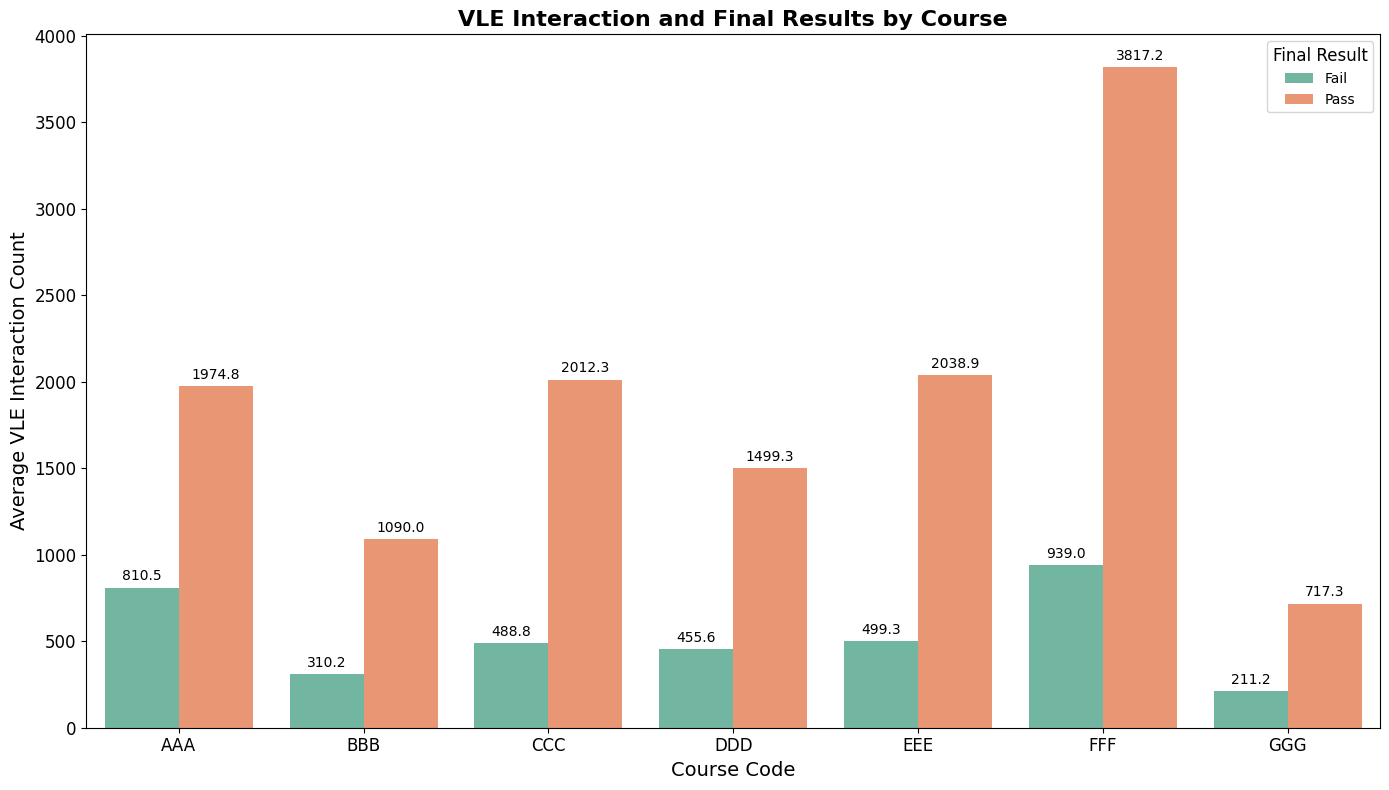

In [16]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Grouping by course (code_module) and final result, and calculating the average total_sum_click (VLE interactions)
interaction_by_course_result = merged_student_info_vle.groupby(['code_module', 'final_result_upd'])['total_sum_click'].mean().reset_index()

# Create the bar plot
sns.barplot(x='code_module', y='total_sum_click', hue='final_result_upd', data=interaction_by_course_result, palette='Set2')

# Add title and axis labels
plt.title('VLE Interaction and Final Results by Course', fontsize=16, fontweight='bold')
plt.xlabel('Course Code', fontsize=14)
plt.ylabel('Average VLE Interaction Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add values on top of bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f', fontsize=10, padding=3)

# Improve legend title and position
plt.legend(title='Final Result', title_fontsize=12, fontsize=10, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


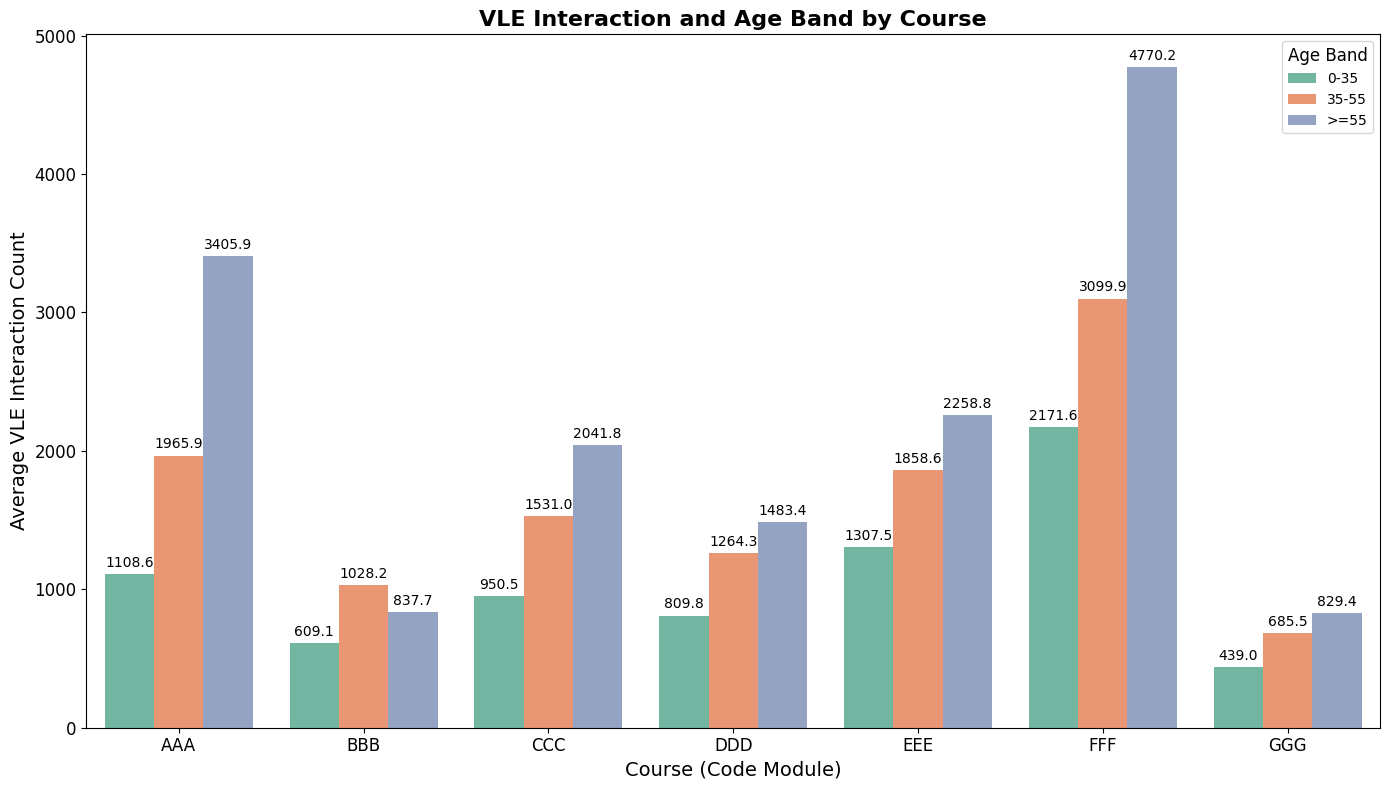

In [17]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Grouping by course (code_module) and age_band, and calculating the average total_sum_click (VLE interactions)
interaction_by_age_band = merged_student_info_vle.groupby(['code_module', 'age_band'])['total_sum_click'].mean().reset_index()

# Create the bar plot
sns.barplot(x='code_module', y='total_sum_click', hue='age_band', data=interaction_by_age_band, palette='Set2')

# Add title and axis labels
plt.title('VLE Interaction and Age Band by Course', fontsize=16, fontweight='bold')
plt.xlabel('Course (Code Module)', fontsize=14)
plt.ylabel('Average VLE Interaction Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value annotations on top of bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f', fontsize=10, padding=3)

# Improve legend appearance
plt.legend(title='Age Band', title_fontsize=12, fontsize=10, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

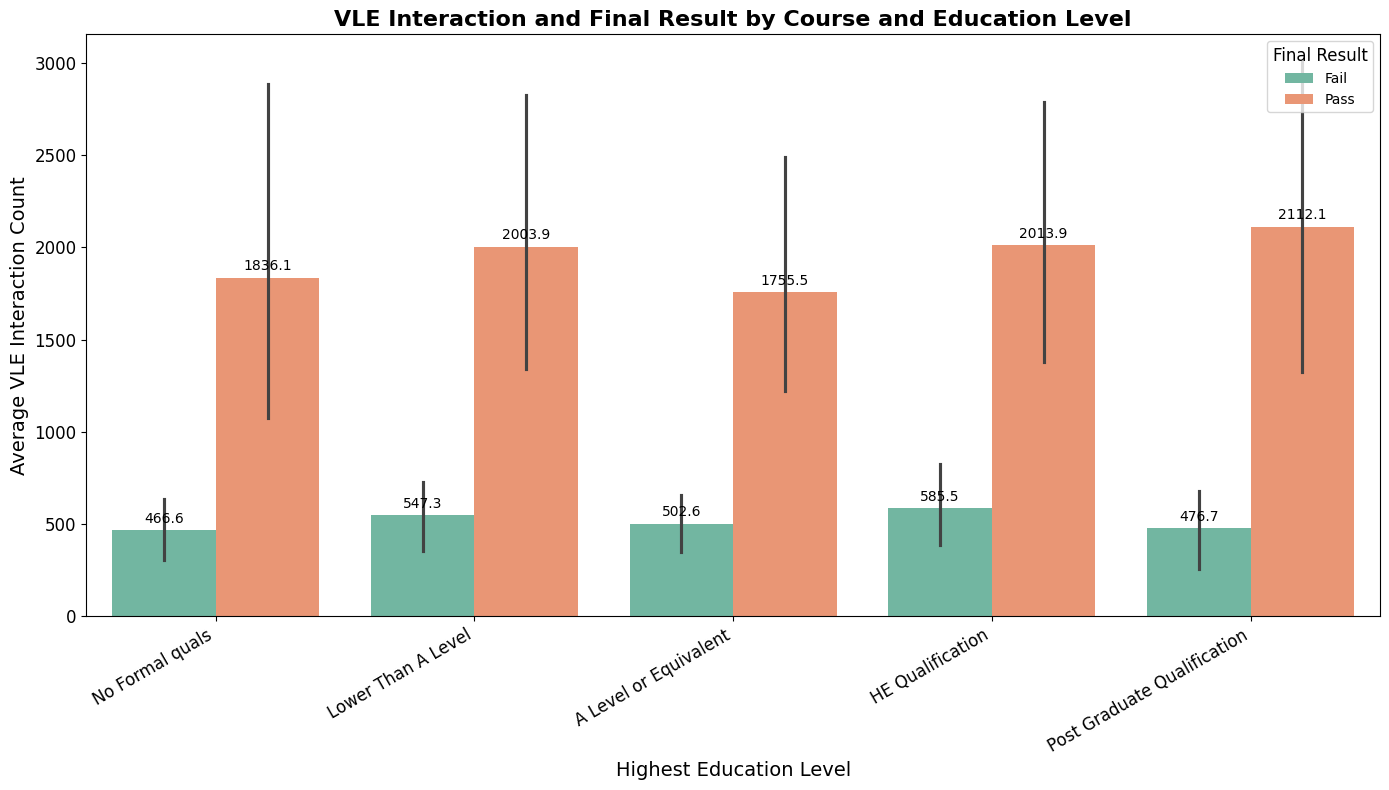

In [18]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Group by highest_education, final_result, and code_module, and calculate the average total_sum_click
interaction_by_age_band = (
    merged_student_info_vle
    .groupby(['highest_education', 'final_result_upd', 'code_module'])['total_sum_click']
    .mean()
    .reset_index()
)

# Create the bar plot with customized order for education levels
sns.barplot(
    x='highest_education', 
    y='total_sum_click', 
    hue='final_result_upd', 
    data=interaction_by_age_band, 
    palette='Set2', 
    order=['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 'HE Qualification', 'Post Graduate Qualification']
)

# Add title and axis labels with improved formatting
plt.title('VLE Interaction and Final Result by Course and Education Level', fontsize=16, fontweight='bold')
plt.xlabel('Highest Education Level', fontsize=14)
plt.ylabel('Average VLE Interaction Count', fontsize=14)
plt.xticks(rotation=30, fontsize=12, ha='right')  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)

# Add value annotations on the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f', fontsize=10, padding=3)

# Improve legend appearance
plt.legend(title='Final Result', title_fontsize=12, fontsize=10, loc='upper right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

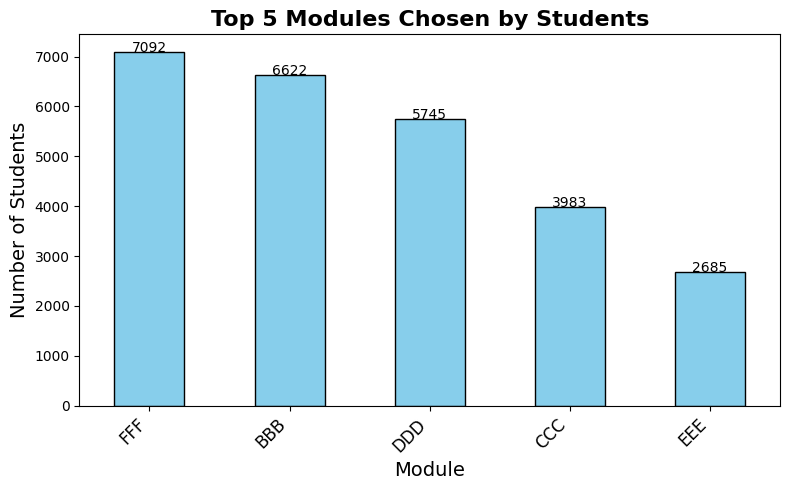

In [19]:
# Count the number of students per module and select the top 5
top_modules = merged_student_info_vle['code_module'].value_counts().head(5)

# Set up the figure size
plt.figure(figsize=(8, 5))

# Plot the top 5 modules as a bar chart
top_modules.plot(kind='bar', color='skyblue', edgecolor='black')

# Add title and axis labels with improved formatting
plt.title('Top 5 Modules Chosen by Students', fontsize=16, fontweight='bold')
plt.xlabel('Module', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, ha='right')

# Add value annotations on top of the bars
for index, value in enumerate(top_modules):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

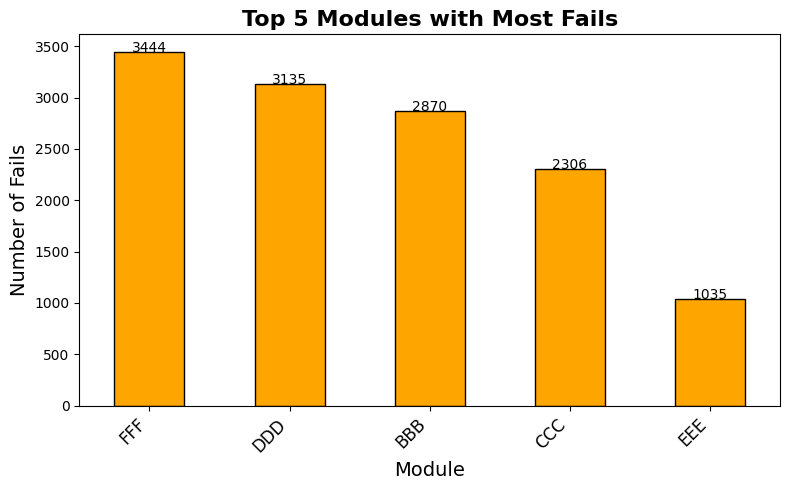

In [20]:
# Count the number of failures per module and sort to get the top 5
failures = (
    merged_student_info_vle[merged_student_info_vle['final_result_upd'] == 'Fail']
    .groupby('code_module').size()
    .sort_values(ascending=False)
    .head(5)
)

# Set up the figure size
plt.figure(figsize=(8, 5))

# Plot the failures as a bar chart
failures.plot(kind='bar', color='orange', edgecolor='black')

# Add title and axis labels with improved formatting
plt.title('Top 5 Modules with Most Fails', fontsize=16, fontweight='bold')
plt.xlabel('Module', fontsize=14)
plt.ylabel('Number of Fails', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, ha='right')

# Add value annotations on top of the bars
for index, value in enumerate(failures):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

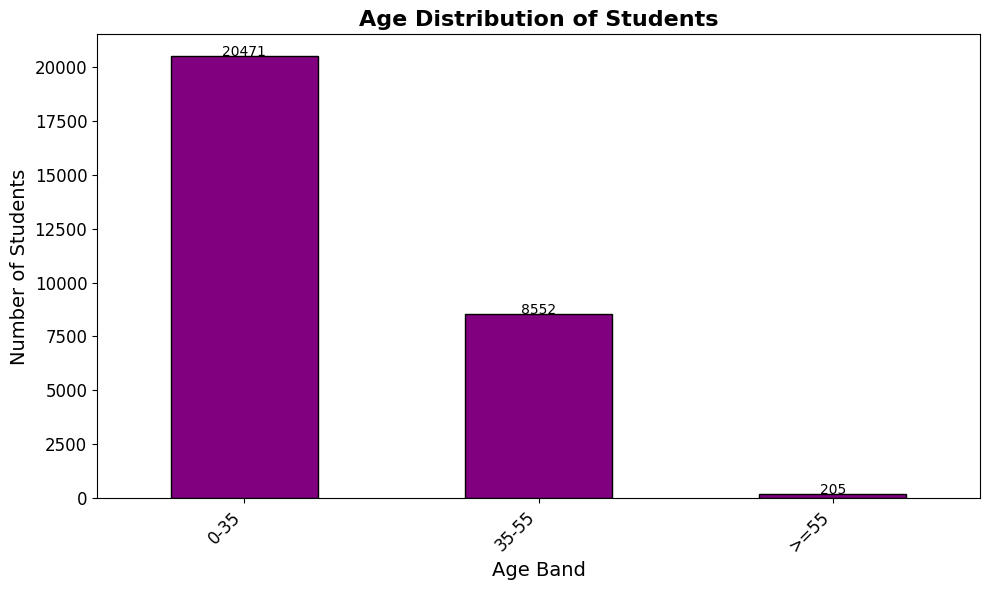

In [21]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the distribution of student ages as a bar chart
merged_student_info_vle['age_band'].value_counts().sort_index().plot(
    kind='bar', color='purple', edgecolor='black'
)

# Add title and axis labels with improved formatting
plt.title('Age Distribution of Students', fontsize=16, fontweight='bold')
plt.xlabel('Age Band', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add value annotations on top of the bars
age_counts = merged_student_info_vle['age_band'].value_counts().sort_index()
for index, value in enumerate(age_counts):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
# Assuming you have your merged dataframe called `merged_student_info_vle`
# Example: merged_student_info_vle = pd.read_csv('your_data.csv')

# 1. Convert 'imd_band' to string to avoid type mismatch errors
merged_student_info_vle['imd_band'] = merged_student_info_vle['imd_band'].astype(str).str.strip()

# 1.1 FIX: Convert imd_band to a numeric value for comparisons
# Extract upper bound from strings like "0-10%", "10-20%" -> 10, 20, ...
imd_upper = pd.to_numeric(
    merged_student_info_vle['imd_band'].str.extract(r"-(\d+)%")[0],
    errors="coerce"
)

# 2. Define conditions to split the IMD Band into 3 categories (0-20, 20-80, 80-100)
conditions = [
    (imd_upper <= 20),
    (imd_upper > 20) & (imd_upper <= 80),
    (imd_upper > 80)
]

# 3. Define the corresponding labels for the conditions
choices = ['0% - 20%', '20% - 80%', '80% - 100%']

# 4. Apply the categorization to create a new column in the dataframe
# FIX: Add default as a STRING so dtype matches (avoid np.select dtype error)
merged_student_info_vle['imd_band_category'] = np.select(conditions, choices, default='Unknown')

# 5. Loop over each course to generate tables for all courses
courses = merged_student_info_vle['code_module'].unique()  # Get all unique courses (code_module)

# Create a dictionary to hold the result tables for each course
course_tables = {}

# Loop over each course to generate the table
for course in courses:
    # 6. Filter the data for the current course
    course_data = merged_student_info_vle[merged_student_info_vle['code_module'] == course]

    # 7. Group the data by 'imd_band_category' and 'final_result_upd',
    # then calculate the count of each final result per IMD band category
    result_counts_by_imd_band = course_data.groupby(['imd_band_category', 'final_result_upd']).size().unstack(fill_value=0)

    # 8. Calculate the percentage for each category
    result_percentage_by_imd_band = result_counts_by_imd_band.div(result_counts_by_imd_band.sum(axis=1), axis=0) * 100

    # Store the table in the dictionary
    course_tables[course] = result_percentage_by_imd_band

# 9. Display the results
for course, table in course_tables.items():
    print(f"\nVLE Interaction and Final Result Percentage for Course: {course}")
    display(table.round(2))



VLE Interaction and Final Result Percentage for Course: AAA


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,33.33,66.67
20% - 80%,27.98,72.02
80% - 100%,26.37,73.63
Unknown,17.39,82.61



VLE Interaction and Final Result Percentage for Course: BBB


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,53.34,46.66
20% - 80%,42.32,57.68
80% - 100%,31.12,68.88
Unknown,25.45,74.55



VLE Interaction and Final Result Percentage for Course: CCC


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,65.73,34.27
20% - 80%,59.88,40.12
80% - 100%,50.88,49.12
Unknown,38.08,61.92



VLE Interaction and Final Result Percentage for Course: DDD


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,66.06,33.94
20% - 80%,55.29,44.71
80% - 100%,47.08,52.92
Unknown,31.60,68.40



VLE Interaction and Final Result Percentage for Course: EEE


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,48.29,51.71
20% - 80%,38.88,61.12
80% - 100%,31.93,68.07
Unknown,25.00,75.00



VLE Interaction and Final Result Percentage for Course: FFF


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,59.85,40.15
20% - 80%,48.59,51.41
80% - 100%,40.05,59.95
Unknown,28.65,71.35



VLE Interaction and Final Result Percentage for Course: GGG


final_result_upd,Fail,Pass
imd_band_category,,
0% - 20%,44.44,55.56
20% - 80%,34.59,65.41
80% - 100%,27.13,72.87
Unknown,28.57,71.43


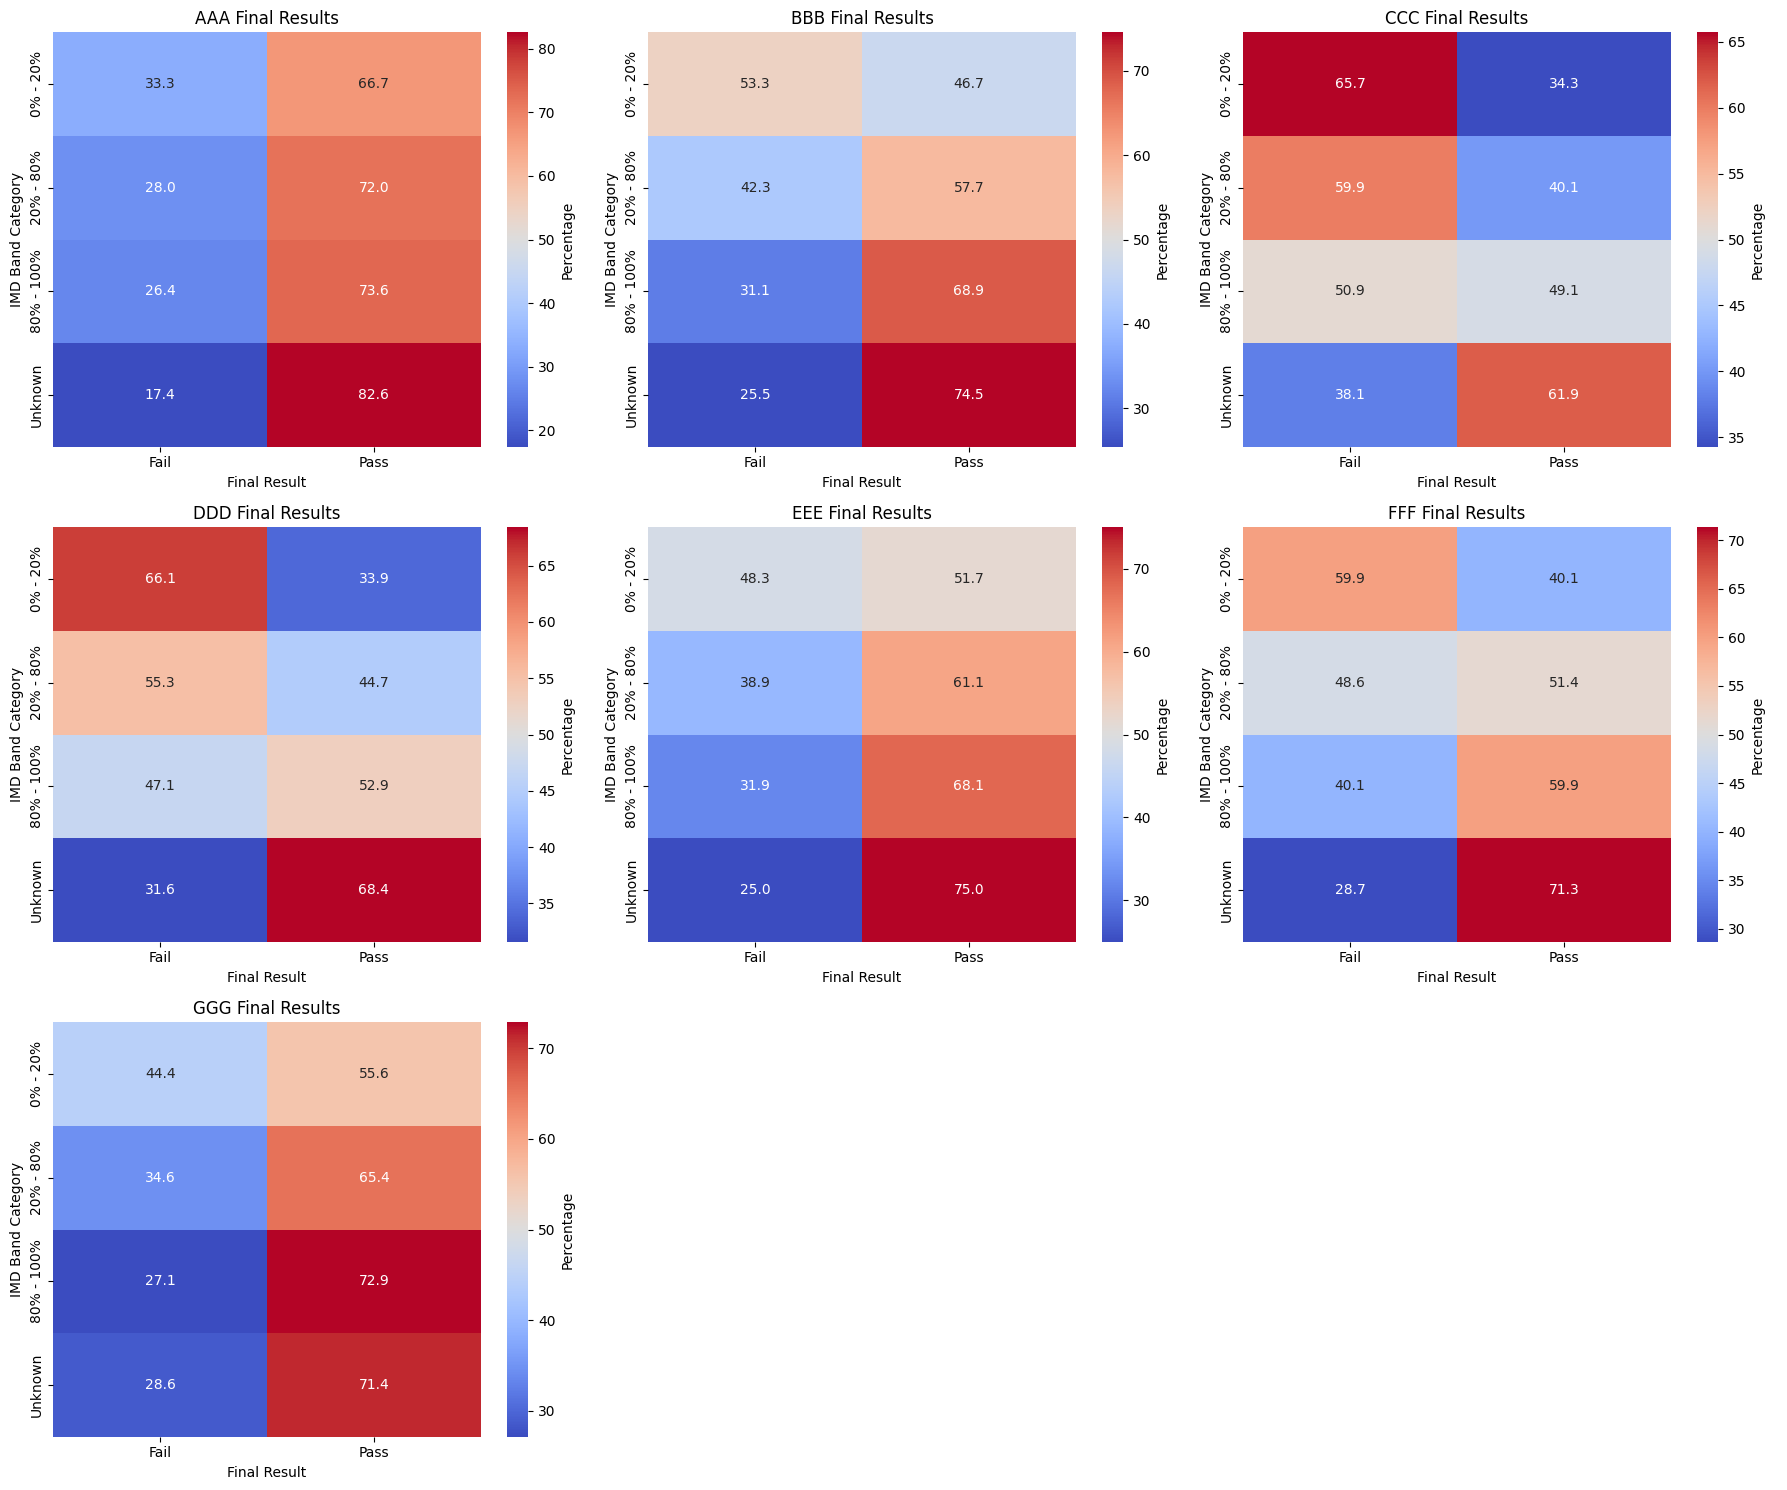

In [23]:
num_courses = len(course_tables)
cols = 3
rows = math.ceil(num_courses / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten() 

for idx, (course, table) in enumerate(course_tables.items()):
    sns.heatmap(
        table, 
        annot=True, 
        fmt='.1f', 
        cmap='coolwarm', 
        cbar_kws={'label': 'Percentage'}, 
        ax=axes[idx]
    )
    axes[idx].set_title(f'{course} Final Results')
    axes[idx].set_xlabel('Final Result')
    axes[idx].set_ylabel('IMD Band Category')

for ax in axes[num_courses:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
#df_student_assessment x df_assessments
merged_student_assessment_ass = pd.merge(
    df_student_assessment,
    df_assessments,
    on=['id_assessment'],
    how='inner'
)

# Calculate weighted scores
merged_student_assessment_ass['weighted_score'] = merged_student_assessment_ass['score'] * (merged_student_assessment_ass['weight'] / 100)

# Checking is_banked column
merged_student_assessment_ass.loc[merged_student_assessment_ass['is_banked'] == 1, 'weighted_score'] = 0

merged_student_assessment_ass

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,weighted_score
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10.0,7.8
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10.0,7.0
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10.0,7.2
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10.0,6.9
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10.0,7.9
...,...,...,...,...,...,...,...,...,...,...,...
173734,37443,527538,227,0,60,GGG,2014J,CMA,229,0.0,0.0
173735,37443,534672,229,0,100,GGG,2014J,CMA,229,0.0,0.0
173736,37443,546286,215,0,80,GGG,2014J,CMA,229,0.0,0.0
173737,37443,546724,230,0,100,GGG,2014J,CMA,229,0.0,0.0


In [25]:
# Grouping and summing weights for each assessment type
weight_summary = df_assessments.groupby(
    ["code_module", "code_presentation", "assessment_type"]
)["weight"].sum().unstack(fill_value=0)

# Ensuring columns for both "Exam" and "<>Exam" exist
if "Exam" not in weight_summary.columns:
    weight_summary["Exam"] = 0
if "TMA" not in weight_summary.columns:
    weight_summary["TMA"] = 0

# Display the result
print(weight_summary)

assessment_type                 CMA   Exam    TMA
code_module code_presentation                    
AAA         2013J               0.0  100.0  100.0
            2014J               0.0  100.0  100.0
BBB         2013B               5.0  100.0   95.0
            2013J               5.0  100.0   95.0
            2014B               5.0  100.0   95.0
            2014J               0.0  100.0  100.0
CCC         2014B              25.0  100.0   75.0
            2014J              25.0  100.0   75.0
DDD         2013B              25.0  100.0   75.0
            2013J               0.0  100.0  100.0
            2014B               0.0  100.0  100.0
            2014J               0.0  100.0  100.0
EEE         2013J               0.0  100.0  100.0
            2014B               0.0  100.0  100.0
            2014J               0.0  100.0  100.0
FFF         2013B               0.0  100.0  100.0
            2013J               0.0  100.0  100.0
            2014B               0.0  100.0  100.0


In [26]:
# Separate exams and non-exams

exam_scores = merged_student_assessment_ass[
    (merged_student_assessment_ass['assessment_type'] == 'Exam') &
    (merged_student_assessment_ass['is_banked'] == 0)
]

non_exam_scores = merged_student_assessment_ass[
    (merged_student_assessment_ass['assessment_type'] != 'Exam') &
    (merged_student_assessment_ass['is_banked'] == 0)
]


# Aggregate scores
exam_grouped = (
    exam_scores.groupby(['id_student', 'code_module', 'code_presentation'])
    .agg(exam_weighted_score=('weighted_score', 'sum'))
    .reset_index()
)

non_exam_grouped = (
    non_exam_scores.groupby(['id_student', 'code_module', 'code_presentation'])
    .agg(non_exam_weighted_score=('weighted_score', 'sum'))
    .reset_index()
)
    

# Merge exam and non-exam scores
final_scores = pd.merge(
    exam_grouped,
    non_exam_grouped,
    on=['id_student', 'code_module', 'code_presentation'],
    how='outer'
).fillna(0)

# Calculate overall grade
final_scores['overall_grade'] = final_scores.apply(
    lambda row: (
        row['exam_weighted_score'] + row['non_exam_weighted_score']
    ) / 2 if row['exam_weighted_score'] > 0 and row['non_exam_weighted_score'] > 0
    else row['exam_weighted_score'] + row['non_exam_weighted_score'],
    axis=1
)

# Display final scores
final_scores.head()

,id_student,code_module,code_presentation,exam_weighted_score,non_exam_weighted_score,overall_grade
0,6516,AAA,2014J,0.0,63.50,63.500
1,8462,DDD,2013J,0.0,34.90,34.900
2,11391,AAA,2013J,0.0,82.40,82.400
3,23629,BBB,2013B,0.0,16.69,16.690
4,23698,CCC,2014J,80.0,69.97,74.985


In [27]:
merged_student_info_vle.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'final_result_upd',
       'final_result_upd_numeric', 'total_sum_click', 'imd_band_category'],
      dtype='object')

In [28]:
final_data = pd.merge(
    final_scores,
    merged_student_info_vle[['id_student', 'code_module', 'code_presentation', 'total_sum_click', 'region', 'imd_band', 'gender','final_result', 'final_result_upd', 'final_result_upd_numeric', 'age_band','highest_education','disability']],
    on=['id_student', 'code_module', 'code_presentation'],
    how='inner'
)

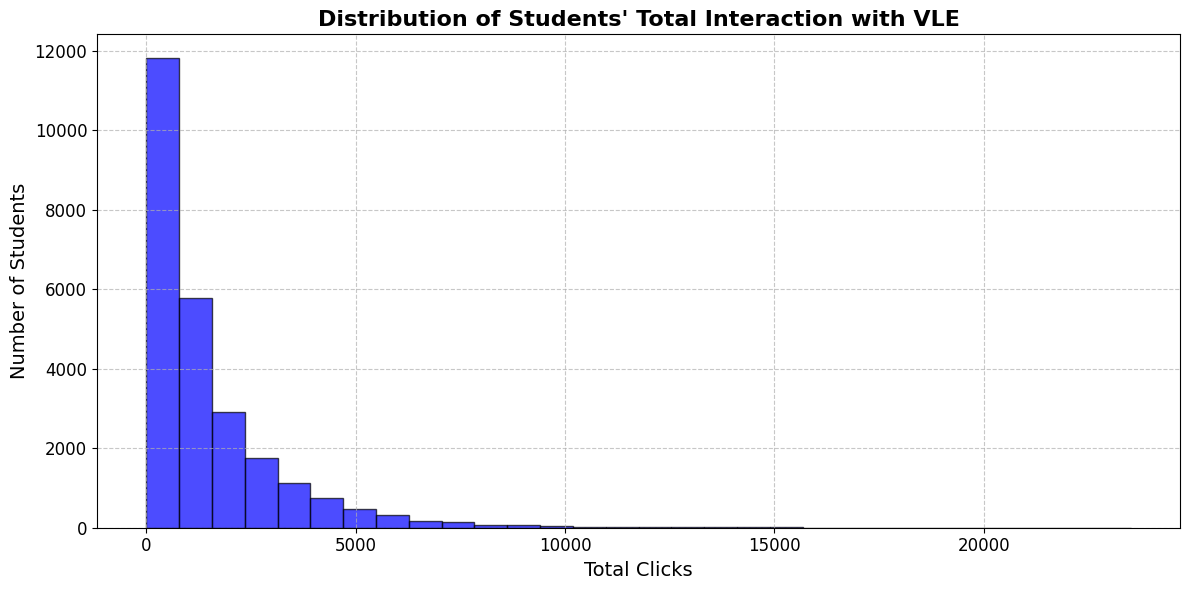

In [29]:
# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot a histogram of total clicks
plt.hist(
    final_data['total_sum_click'], 
    bins=30, 
    color='blue', 
    edgecolor='black', 
    alpha=0.7
)

# Add title and axis labels with improved formatting
plt.title("Distribution of Students' Total Interaction with VLE", fontsize=16, fontweight='bold')
plt.xlabel("Total Clicks", fontsize=14)
plt.ylabel("Number of Students", fontsize=14)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust tick font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

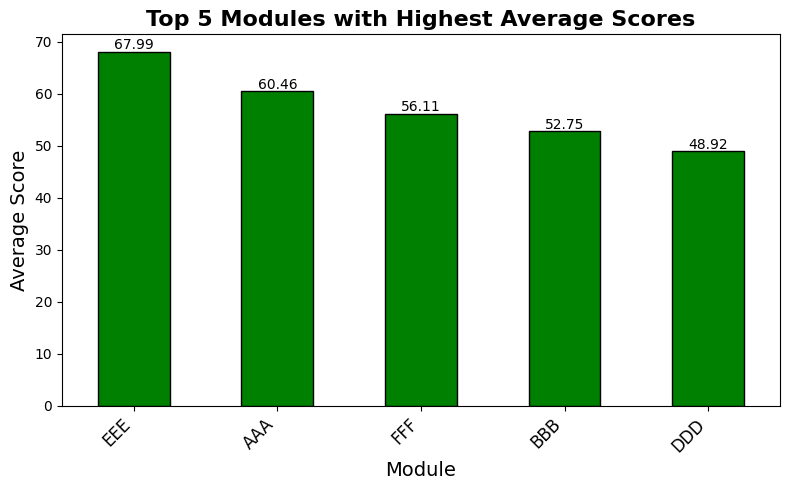

In [30]:
# Calculate the average score per module and select the top 5
average_scores = (
    final_data.groupby('code_module')['overall_grade']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Set up the figure size
plt.figure(figsize=(8, 5))

# Plot the average scores as a bar chart
average_scores.plot(kind='bar', color='green', edgecolor='black')

# Add title and axis labels with improved formatting
plt.title('Top 5 Modules with Highest Average Scores', fontsize=16, fontweight='bold')
plt.xlabel('Module', fontsize=14)
plt.ylabel('Average Score', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, ha='right')

# Add value annotations on top of the bars
for index, value in enumerate(average_scores):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

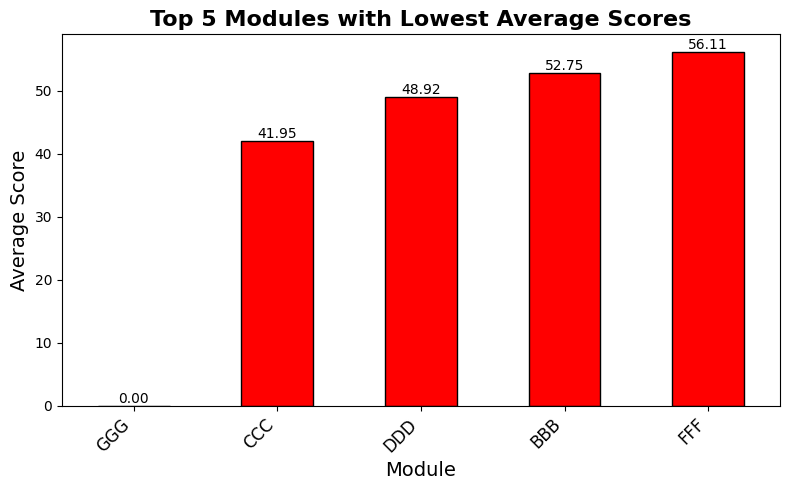

In [31]:
# Calculate the lowest average scores per module and select the bottom 5
lowest_scores = (
    final_data.groupby('code_module')['overall_grade']
    .mean()
    .sort_values(ascending=True)
    .head(5)
)

# Set up the figure size
plt.figure(figsize=(8, 5))

# Plot the lowest scores as a bar chart
lowest_scores.plot(kind='bar', color='red', edgecolor='black')

# Add title and axis labels with improved formatting
plt.title('Top 5 Modules with Lowest Average Scores', fontsize=16, fontweight='bold')
plt.xlabel('Module', fontsize=14)
plt.ylabel('Average Score', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, ha='right')

# Add value annotations on top of the bars
for index, value in enumerate(lowest_scores):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
# Results list to store analysis for each module
results = []

# Iterate over each unique module
for module in final_data['code_module'].unique():
    # Filter data for the specific module
    module_data = final_data[final_data['code_module'] == module]
    
    # Separate Pass and Fail students based on final_result
    pass_students = module_data[module_data['final_result_upd'] == 'Pass']['total_sum_click']
    fail_students = module_data[module_data['final_result_upd'] == 'Fail']['total_sum_click']
    
    # Perform t-test after removing NaN values
    t_stat, p_val = ttest_ind(pass_students.dropna(), fail_students.dropna(), equal_var=False)
    
    # Interpret the result
    if p_val < 0.05:
        if t_stat > 0:
            comment = "There is a significant difference (p < 0.05). Passing students used the VLE more."
        else:
            comment = "There is a significant difference (p < 0.05). Failing students used the VLE more."
    else:
        comment = "No significant difference (p > 0.05)."
    
    # Append results
    results.append({
        "Module": module,
        "T-Statistic": round(t_stat, 2),
        "P-Value": f"{p_val:.2e}",
        "Comment": comment
    })

# Convert results to a DataFrame
dynamic_results_df = pd.DataFrame(results)

pd.set_option('display.max_colwidth', None)
display(dynamic_results_df)

,Module,T-Statistic,P-Value,Comment
0,AAA,8.66,8.14e-17,There is a significant difference (p < 0.05). Passing students used the VLE more.
1,DDD,31.57,2.74e-195,There is a significant difference (p < 0.05). Passing students used the VLE more.
2,BBB,28.12,4.18e-163,There is a significant difference (p < 0.05). Passing students used the VLE more.
3,CCC,27.94,4.38e-148,There is a significant difference (p < 0.05). Passing students used the VLE more.
4,GGG,21.70,3.93e-93,There is a significant difference (p < 0.05). Passing students used the VLE more.
5,EEE,32.67,3.02e-192,There is a significant difference (p < 0.05). Passing students used the VLE more.
6,FFF,58.63,0.00e+00,There is a significant difference (p < 0.05). Passing students used the VLE more.


Linear Model Coefficients: a = 0.0089, b = 35.4220
Linear Model RMSE: 27.5472


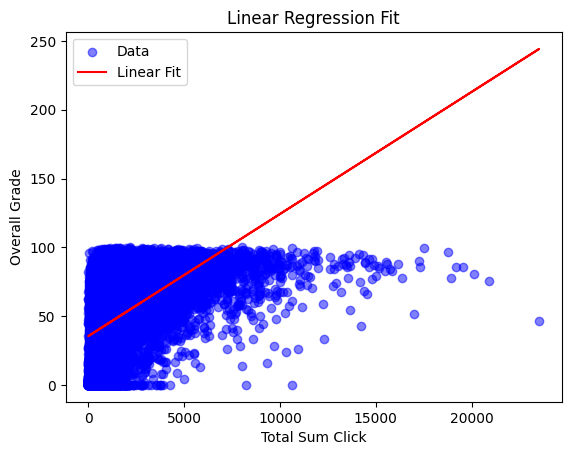

In [33]:
## Curve Fitting - Lineer Regression
X = final_data['total_sum_click']
Y = final_data['overall_grade']

# 1. Define the linear function
def linear_func(x, a, b):
    return a * x + b

# Apply curve fitting (Linear Model)
popt_linear, _ = curve_fit(linear_func, X, Y)

# Make predictions (Linear Model)
Y_pred_linear = linear_func(X, *popt_linear)

# Error measurement (RMSE - Linear Model)
rmse_linear = np.sqrt(np.mean((Y - Y_pred_linear)**2))

# Print results
print(f"Linear Model Coefficients: a = {popt_linear[0]:.4f}, b = {popt_linear[1]:.4f}")
print(f"Linear Model RMSE: {rmse_linear:.4f}")

# Visualization
plt.scatter(X, Y, label='Data', color='blue', alpha=0.5)
plt.plot(X, Y_pred_linear, label='Linear Fit', color='red')
plt.legend()
plt.xlabel('Total Sum Click')
plt.ylabel('Overall Grade')
plt.title('Linear Regression Fit')
plt.show()


In [34]:
# Apply one-hot encoding with drop_first=True
data_encoded = pd.get_dummies(final_data, columns=['code_module', 'code_presentation', 'region',
                                                   'imd_band', 'gender', 'age_band',
                                                   'highest_education', 'disability'], drop_first=True)

# Check the columns to find the correct target variable
print(data_encoded.columns)

Index(['id_student', 'exam_weighted_score', 'non_exam_weighted_score',
       'overall_grade', 'total_sum_click', 'final_result', 'final_result_upd',
       'final_result_upd_numeric', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B',
       'code_presentation_2014J', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'imd_band_10-20%', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%',
       'imd_band_nan', 'gender_M', 'age_band_35-55', 'age_band_>=55',
  

In [35]:
data_encoded = data_encoded.astype({col:'int64' for col in data_encoded.select_dtypes('bool').columns})

# Define X and y
# Note: Choose one of the dummy columns created from 'final_result_upd' as the target
y = data_encoded['final_result_upd_numeric']
X = data_encoded.drop(columns=['id_student', 'exam_weighted_score', 'non_exam_weighted_score',
       'overall_grade','final_result', 'final_result_upd', 'final_result_upd_numeric'])  # Drop both to avoid duplication

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [36]:
scaler = StandardScaler()
X_train_sm = sm.add_constant(X_train)
model = sm.MNLogit(y_train, X_train_sm)
res = model.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.488682
         Iterations 7
                             MNLogit Regression Results                             
Dep. Variable:     final_result_upd_numeric   No. Observations:                20432
Model:                              MNLogit   Df Residuals:                    20391
Method:                                 MLE   Df Model:                           40
Date:                      Mon, 26 Jan 2026   Pseudo R-squ.:                  0.2735
Time:                              11:17:03   Log-Likelihood:                -9984.7
converged:                             True   LL-Null:                       -13744.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                   final_result_upd_numeric=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [37]:
#Prediction
X_test_sm = sm.add_constant(X_test)
y_pred = res.predict(X_test_sm).idxmax(axis=1)
y_test = y_test.reset_index(drop=True)

# Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test , y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1)

Accuracy:  0.7839107457428068
Precision:  0.7825062615799825
Recall:  0.7839107457428068
F1 Score:  0.7829228912468792


In [38]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Logistic Regression Model
logreg = LogisticRegression(max_iter=100)

# Number of features to select
num_features = [5, 10, 15, 20]
rfe_features = {nf: {} for nf in num_features}

# Selecting Features with RFE
for nf in num_features:
    rfe = RFE(logreg, n_features_to_select=nf)
    rfe = rfe.fit(X_scaled, y_train)
    selected_features = X_train.columns[rfe.support_]
    rfe_features[nf] = {"score": rfe.score(X_scaled, y_train), "features": selected_features.tolist()}

# Print results
for nf, details in rfe_features.items():
    print(f"Selecting feature's count: {nf}")
    print(f"Model Score: {details['score']}")
    print(f"Selected features: {details['features']}", "\n")


Selecting feature's count: 5
Model Score: 0.7712411902897416
Selected features: ['total_sum_click', 'code_module_BBB', 'code_module_FFF', 'code_module_GGG', 'highest_education_Lower Than A Level'] 

Selecting feature's count: 10
Model Score: 0.7696260767423649
Selected features: ['total_sum_click', 'code_module_BBB', 'code_module_CCC', 'code_module_DDD', 'code_module_FFF', 'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B', 'code_presentation_2014J', 'highest_education_Lower Than A Level'] 

Selecting feature's count: 15
Model Score: 0.773835160532498
Selected features: ['total_sum_click', 'code_module_BBB', 'code_module_CCC', 'code_module_DDD', 'code_module_EEE', 'code_module_FFF', 'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B', 'code_presentation_2014J', 'imd_band_90-100%', 'imd_band_nan', 'gender_M', 'age_band_35-55', 'highest_education_Lower Than A Level'] 

Selecting feature's count: 20
Model Score: 0.7774079874706343
Selected features

In [39]:
selected_features = [
    'total_sum_click',
    'code_module_BBB',
    'code_module_CCC',
    'code_module_FFF',
    'code_module_GGG',
    'imd_band_90-100%',
    'imd_band_70-80%',
    'highest_education_Lower Than A Level',
    'age_band_35-55',
    'code_presentation_2013J'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model_selected_feature = sm.MNLogit(y_train, sm.add_constant(X_train_selected))
final_res = model_selected_feature.fit()

print(final_res.summary())

Optimization terminated successfully.
         Current function value: 0.498555
         Iterations 7
                             MNLogit Regression Results                             
Dep. Variable:     final_result_upd_numeric   No. Observations:                20432
Model:                              MNLogit   Df Residuals:                    20421
Method:                                 MLE   Df Model:                           10
Date:                      Mon, 26 Jan 2026   Pseudo R-squ.:                  0.2588
Time:                              11:17:07   Log-Likelihood:                -10186.
converged:                             True   LL-Null:                       -13744.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
          final_result_upd_numeric=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const   

In [40]:
#Prediction
y_pred = final_res.predict(sm.add_constant(X_test_selected))
y_pred_selected = y_pred.idxmax(axis=1)
y_test = y_test.reset_index(drop=True)

# Performance
accuracy = accuracy_score(y_test, y_pred_selected)
precision = precision_score(y_test, y_pred_selected, average='weighted')
recall = recall_score(y_test , y_pred_selected, average='weighted')
f1 = f1_score(y_test, y_pred_selected, average='weighted')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1)

Accuracy:  0.7803875513799178
Precision:  0.7789698614573574
Recall:  0.7803875513799178
F1 Score:  0.7794063635733561


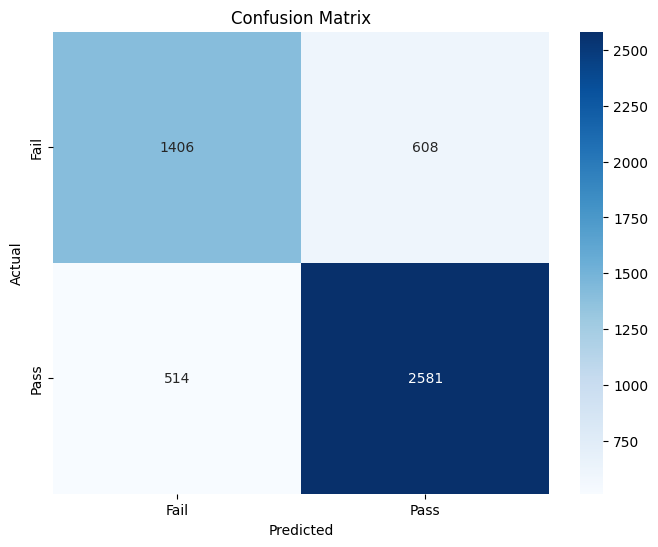

Classification Report:
               precision    recall  f1-score   support

        Fail       0.73      0.70      0.71      2014
        Pass       0.81      0.83      0.82      3095

    accuracy                           0.78      5109
   macro avg       0.77      0.77      0.77      5109
weighted avg       0.78      0.78      0.78      5109



In [41]:
X_test_sm = sm.add_constant(X_test_selected)
yhat = final_res.predict(X_test_sm).idxmax(axis=1)

#confusion matrix
cm = confusion_matrix(y_test,yhat)

#Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'],  yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, yhat, target_names=['Fail', 'Pass'])
print("Classification Report:\n", report)

## Bonus: Compare Multiple Algorithms

This section trains **several classification models** (Logistic Regression, Decision Tree, Random Forest, KNN) on the same processed dataset and produces:

- A **metrics comparison table** (Accuracy, Precision, Recall, F1, ROC-AUC)
- **Confusion matrices** for the top models
- **ROC** and **Precision–Recall** curves (optional but helpful)


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Ensure y is 1D numpy array
y_train_np = np.asarray(y_train)
y_test_np  = np.asarray(y_test)

def evaluate_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    # Probabilities for AUC/curves (if available)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        # map decision_function to pseudo-probability scale for AUC only
        scores = model.decision_function(Xte)
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

    metrics = {
        "model": name,
        "accuracy": accuracy_score(yte, pred),
        "precision": precision_score(yte, pred, zero_division=0),
        "recall": recall_score(yte, pred, zero_division=0),
        "f1": f1_score(yte, pred, zero_division=0),
        "roc_auc": roc_auc_score(yte, proba) if proba is not None else np.nan,
    }
    return metrics, pred, proba, model

# (To compare on all features instead, change X_train_selected -> X_train and X_test_selected -> X_test)
Xtr = X_train_selected.copy()
Xte = X_test_selected.copy()

models = {
    "LogReg (balanced)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1
    ),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=15))
    ]),
}

results = []
pred_store = {}
proba_store = {}
model_store = {}  # store fitted models for later inspection

for name, model in models.items():
    m, pred, proba, fitted = evaluate_model(name, model, Xtr, y_train_np, Xte, y_test_np)
    results.append(m)
    pred_store[name] = pred
    proba_store[name] = proba
    model_store[name] = fitted

results_df = pd.DataFrame(results).sort_values(["f1", "recall"], ascending=False).reset_index(drop=True)
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,KNN,0.787630,0.799285,0.867205,0.831861,0.846222
1,LogReg (balanced),0.757878,0.855666,0.722132,0.783249,0.849184
2,RandomForest,0.733216,0.784121,0.772213,0.778121,0.811897
3,DecisionTree,0.715991,0.777515,0.744103,0.760442,0.716707


In [43]:
# Save comparison table for your report / submission
out_csv = os.path.join(OUTPUT_DIR, "model_comparison_metrics.csv")
results_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: .\outputs\model_comparison_metrics.csv


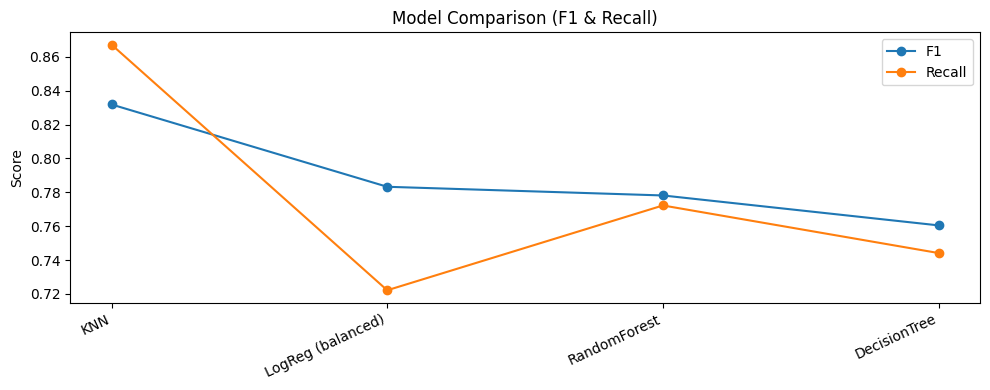

In [44]:

# Plot a quick comparison chart (F1 and Recall)
plt.figure(figsize=(10,4))
plt.plot(results_df["model"], results_df["f1"], marker="o", label="F1")
plt.plot(results_df["model"], results_df["recall"], marker="o", label="Recall")
plt.xticks(rotation=25, ha="right")
plt.ylabel("Score")
plt.title("Model Comparison (F1 & Recall)")
plt.legend()
plt.tight_layout()
plt.show()


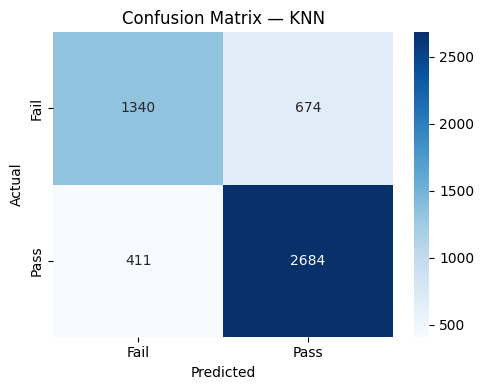


Classification report — KNN
              precision    recall  f1-score   support

        Fail       0.77      0.67      0.71      2014
        Pass       0.80      0.87      0.83      3095

    accuracy                           0.79      5109
   macro avg       0.78      0.77      0.77      5109
weighted avg       0.79      0.79      0.78      5109



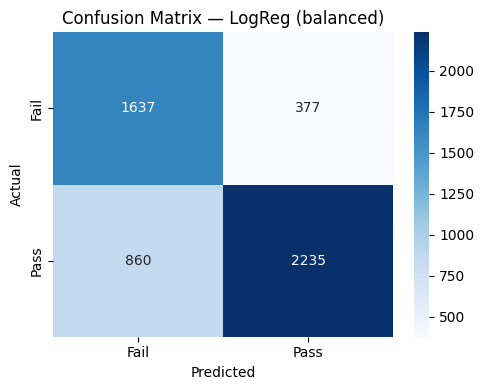


Classification report — LogReg (balanced)
              precision    recall  f1-score   support

        Fail       0.66      0.81      0.73      2014
        Pass       0.86      0.72      0.78      3095

    accuracy                           0.76      5109
   macro avg       0.76      0.77      0.75      5109
weighted avg       0.78      0.76      0.76      5109



In [45]:

# Confusion matrices for top-2 models by F1
top_models = results_df["model"].head(2).tolist()

for name in top_models:
    cm = confusion_matrix(y_test_np, pred_store[name])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"])
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print(f"\nClassification report — {name}")
    print(classification_report(y_test_np, pred_store[name], target_names=["Fail","Pass"]))


<Figure size 600x500 with 0 Axes>

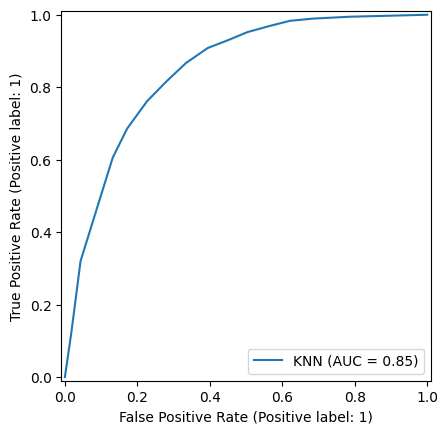

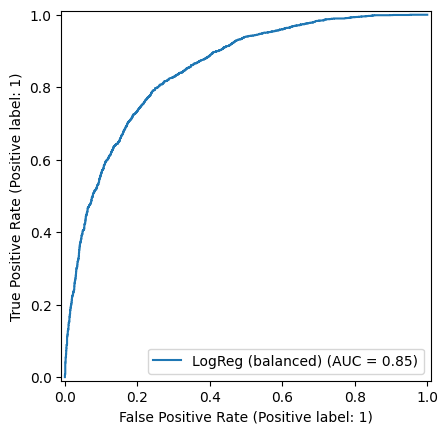

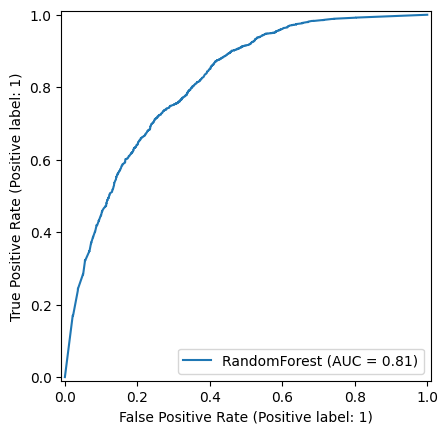

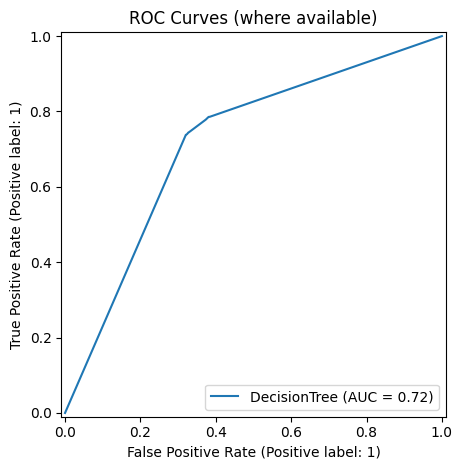

<Figure size 600x500 with 0 Axes>

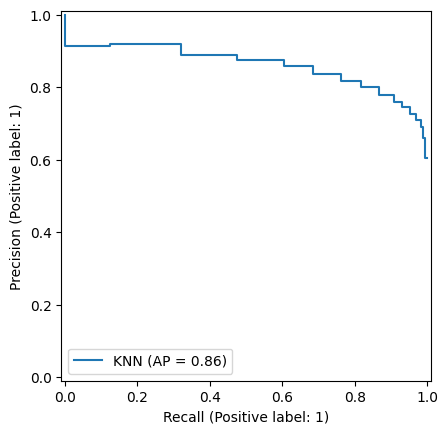

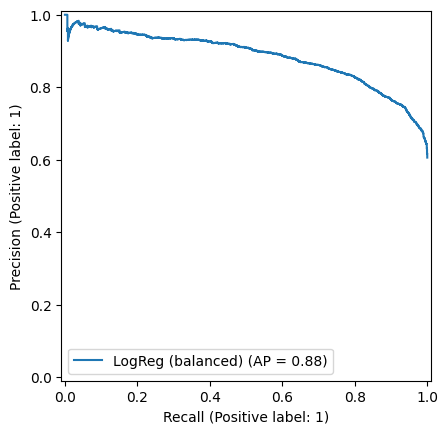

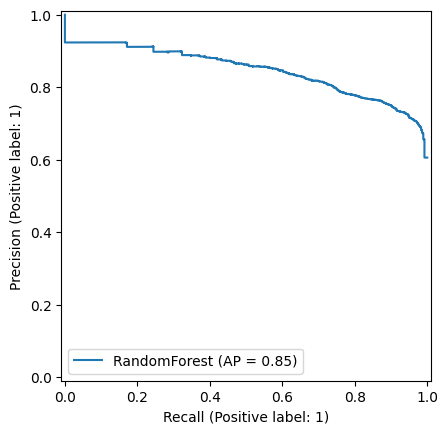

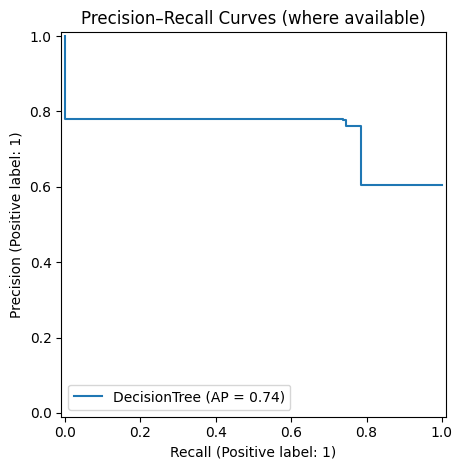

In [ ]:
# ROC + Precision-Recall curves for models that output probabilities/scores
plt.figure(figsize=(6,5))
for name in results_df["model"]:
    proba = proba_store.get(name)
    if proba is None or np.isnan(proba).all():
        continue
    RocCurveDisplay.from_predictions(y_test_np, proba, name=name)
plt.title("ROC Curves (where available)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
for name in results_df["model"]:
    proba = proba_store.get(name)
    if proba is None or np.isnan(proba).all():
        continue
    PrecisionRecallDisplay.from_predictions(y_test_np, proba, name=name)
plt.title("Precision–Recall Curves (where available)")
plt.tight_layout()
plt.show()


,feature,importance
0,total_sum_click,0.864858
1,code_module_FFF,0.034070
2,code_module_BBB,0.023122
3,code_module_GGG,0.022352
4,highest_education_Lower Than A Level,0.018184
5,age_band_35-55,0.009589
6,code_presentation_2013J,0.007727
7,code_module_CCC,0.007531
8,imd_band_70-80%,0.006673
9,imd_band_90-100%,0.005895


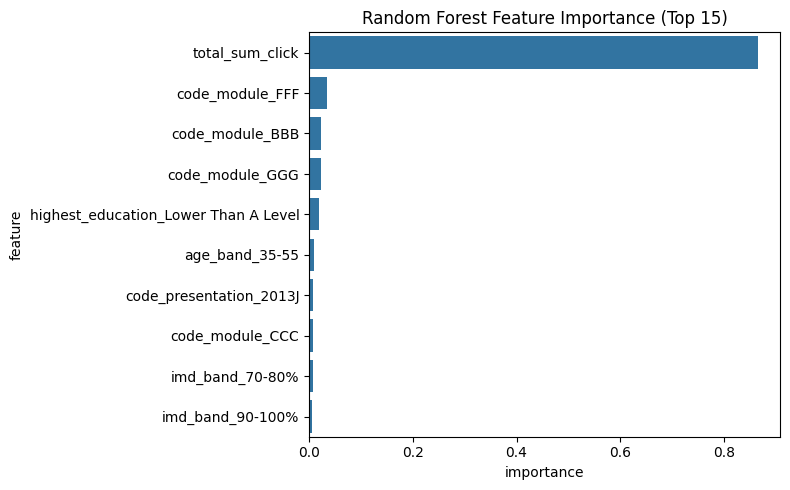

Saved: .\outputs\random_forest_feature_importance.csv


In [ ]:
# Feature importance from Random Forest
# Works only for the plain RandomForest model (not pipelines).

rf_key = "RandomForest"
if rf_key in model_store:
    rf_model = model_store[rf_key]
    if hasattr(rf_model, "feature_importances_"):
        importances = rf_model.feature_importances_
        feat_names = list(X_train_selected.columns)
        feat_imp = (
            pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )
        display(feat_imp.head(20))

        # Plot top 15
        top_n = 15
        plt.figure(figsize=(8, 5))
        sns.barplot(data=feat_imp.head(top_n), x="importance", y="feature")
        plt.title("Random Forest Feature Importance (Top 15)")
        plt.tight_layout()
        plt.show()

        # Save to outputs
        out_csv = os.path.join(OUTPUT_DIR, "random_forest_feature_importance.csv")
        feat_imp.to_csv(out_csv, index=False)
        print("Saved:", out_csv)
    else:
        print("RandomForest model does not expose feature_importances_.")
else:
    print("RandomForest model not found in model_store (did the bonus cell run?).")
